In [103]:
# This is a script to generate a single 2D map of double dot system 

import numpy as np
import imp
import sys
import os
import time
import copy
import multiprocessing as mp

sys.path.append(os.path.expanduser('~/quantum-ml/nanowire_model'))
import potential_profile
imp.reload(markov)
import markov
import exceptions

# wrapper around the base markov class functions
# this function also handles the NoBarrier and InvalidChargeState exceptions
def calculate_current(param):
    graph = param[0]
    physics_model = param[1]
    try:
        graph.physics = physics_model
        graph.tf.__init__(physics_model)
        graph.find_n_dot_estimate()
        graph.find_start_node()
        graph.generate_graph()
        return graph.get_output()
    except exceptions.NoBarrierState:
        output = {}
        output['current'] = graph.tf.short_circuit_current
        output['charge_state'] = (0,)
        output['prob_dist'] = (0,)
        output['num_dot'] = 0
        output['state'] = 'ShortCircuit'
        return output
    except exceptions.InvalidChargeState:
        output = {}
        output['current'] = 0
        output['charge_state'] = (0,)
        output['prob_dist'] = (0,)
        output['num_dot'] = 0
        output['state'] = 'NoDot'
        return output

def get_random(mean,sigma_mean = 0.05):
    return np.random.normal(mean,sigma_mean*np.abs(mean))
    
physics_model = {}
# multiple of eV
physics_model['E_scale'] = 1
# multiple of nm
physics_model['dx_scale'] = 1
physics_model['kT'] = 2000e-6

# just initial param to generate the graph object
b1 = [-200e-3,-0.6,0.05,1]
d1 = [200e-3,-0.1,0.05,1]
b2 = [-350e-3,0.0,0.05,1]
d2 = [200e-3,0.1,0.05,1]
b3 = [-200e-3,0.6,0.05,1]


x = np.linspace(-1,1,100)
physics_model['x'] = x
physics_model['list_b'] = [b1,d1,b2,d2,b3]
physics_model['V'] = potential_profile.V_x_wire(x,physics_model['list_b'])


physics_model['K_onsite'] = 5e-3
physics_model['sigma'] = x[1] - x[0]
physics_model['x_0'] = 0.01*(x[1] - x[0])
physics_model['mu_l'] = (200.0e-3,200.1e-3)
physics_model['battery_weight'] = 10
physics_model['short_circuit_current'] = 1

graph_model = (2,1)
tf_strategy = 'simple'

graph = markov.Markov(graph_model,physics_model,tf_strategy)
graph.find_n_dot_estimate()


N_v = 100
V_d_vec = np.linspace(150e-3,250e-3,N_v)
output_vec = []
input_vec = []
st = time.time()
for i in range(N_v):
    print(i)
    for j in range(N_v):
        d1[0] = V_d_vec[i]
        d2[0] = V_d_vec[j]
        physics_model['list_b'] = [b1,d1,b2,d2,b3]
        V = potential_profile.V_x_wire(x,physics_model['list_b'])
        physics_model['V'] = potential_profile.V_x_wire(x,[b1,b2,b3,d1,d2])
        output_vec += [calculate_current((graph,physics_model))]
print("time",time.time() - st)

# store the data
# data is a list of dictonaries, with key 'output'
data = []
for i in range(len(output_vec)):
    data += [{'output' : output_vec[i]}]

import datetime
dt = str(datetime.datetime.now()) 
np.save(os.path.expanduser('~/datadump/double_dot_' + str(N_v) + '_grid_' + dt + '.npy'),data)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
time 1492.3535649776459


In [89]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
N_v = 100
#plt.pcolor(data.item()['net_charge_map'])
current_map = np.array([x['output']['current'] for x in data]).reshape((N_v,N_v))


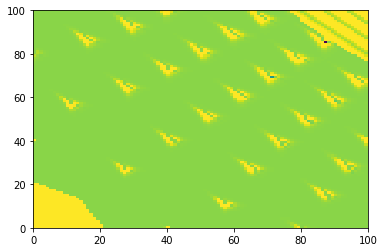

In [100]:
plt.pcolor(current_map,vmax=1e-3)

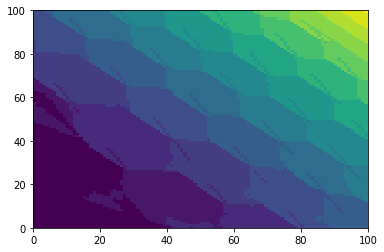

In [101]:
plt.pcolor(np.array([np.sum(x['output']['charge_state']) for x in data]).reshape((N_v,N_v)))

In [13]:
data[50000]['output']['current']

0.0040211419251779245